<a href="https://colab.research.google.com/github/JuanArmas/BigDataSNS/blob/main/Actividad_3_7_Terremotos_Juan_Armas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad_3_7_Predicción de Riesgo de derrumbamiento - Terremotos

#Autor:
Juan Airam Armas Alemán

#Github:
https://github.com/JuanArmas/BigDataSNS/blob/main/Actividad_3_7_Terremotos_Juan_Armas.ipynb
#Drive:
https://drive.google.com/drive/folders/1Jxc5SQ6ImP0X97n1zVE8vFDCV0RHCCa4?usp=sharing


#Entendiendo el problema:
Estamos tratando de predecir la variable ordinal "damage_grade" , que representa un nivel de daño al edificio que fue golpeado por el terremoto. Hay 3 grados de daño:

1 representa un daño bajo
2 representa una cantidad media de daño
3 representa una destrucción casi completa

**Datos Categóricos:**

Estas letras generalmente se refieren a diferentes tipos de cimientos:

- **R**: Es una gran losa de concreto que sostiene toda la estructura.
- **W**: Implica excavar el suelo a una profundidad considerable y construir una estructura similar a un pozo para sostener el edificio, entiendo que son cimientos.
- **I**: Representa una cimentación “Aislada”, donde zapatas individuales sostienen columnas de forma independiente, permitiendo cierto grado de movimiento.
- **U**: Significa cimentación “Subescariada”, que implica ampliar la base de la cimentación para brindar mayor estabilidad.
- **H**: Se refiere a cimientos de “pilotes”, donde columnas verticales (pilotes) se hunden profundamente en el suelo para soportar la estructura.

**Datasets**
- **Valores de entrenamiento:** Son las características que se usará para entrenar un modelo. Hay 38 características, incluyendo información estructural como el número de pisos (antes del terremoto), edad del edificio y tipo de cimientos, así como información legal como el estado de propiedad, el uso del edificio y el número de familias que viven. allá. Cada edificio está identificado por un código único (aleatorio) building_id, que se puede utilizar como índice.

- **Etiquetas de entrenamiento**: ESon las etiquetas. Cada uno building_idde los datos de los valores de entrenamiento tiene una etiqueta correspondiente en este archivo. 1 representa un daño bajo, 2 representa una cantidad media de daño y 3 representa una destrucción casi completa.

- **Valores de prueba:** estas son las funciones que se usará para hacer predicciones después de entrenar un modelo. No le damos las etiquetas para estas muestras, Tengo que generar predicciones del nivel de daño sísmico para estas building_idmuestras

In [117]:
# pip install lazypredict

In [118]:
# pip install h2o

In [119]:
import os
import io
import h2o
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#========================

from sklearn.svm import SVC
from google.colab import drive
from google.colab import files
from collections import Counter
from h2o.automl import H2OAutoML
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import RandomOverSampler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, KFold,cross_val_score, GridSearchCV, cross_val_predict,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, classification_report,recall_score, f1_score


# from sklearn import tree
# from sklearn.impute import SimpleImputer
# from scipy.stats import randint as sp_randint
# from sklearn.linear_model import LogisticRegression
# from sklearn.utils import shuffle,resample,validation
# from sklearn.tree import plot_tree,DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier



In [120]:
# Generamos acceso al drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
# Cargamos la información del drive para poder acceder a ella
train_values_path = "/content/drive/MyDrive/Practica_Terremotos/04.train_values_sampled.csv"
test_values_path = "/content/drive/MyDrive/Practica_Terremotos/05.test_values_sampled.csv"
train_labels_path = "/content/drive/MyDrive/Practica_Terremotos/06.train_labels_sampled.csv"
# train_values_path = "/content/drive/MyDrive/Practica_Terremotos/train_values.csv"
# test_values_path = "/content/drive/MyDrive/Practica_Terremotos/test_values.csv"
# train_labels_path = "/content/drive/MyDrive/Practica_Terremotos/train_labels.csv"

In [122]:
# Establecemos la columna 'building_id' como el índice para los DataFrames resultantes
train_values_df = pd.read_csv(train_values_path, index_col='building_id')
test_values_df = pd.read_csv(test_values_path, index_col='building_id')
train_labels_df = pd.read_csv(train_labels_path, index_col='building_id')

<Axes: title={'center': 'Cantidad de edificios con El tipo de daño sufrido'}, xlabel='damage_grade'>

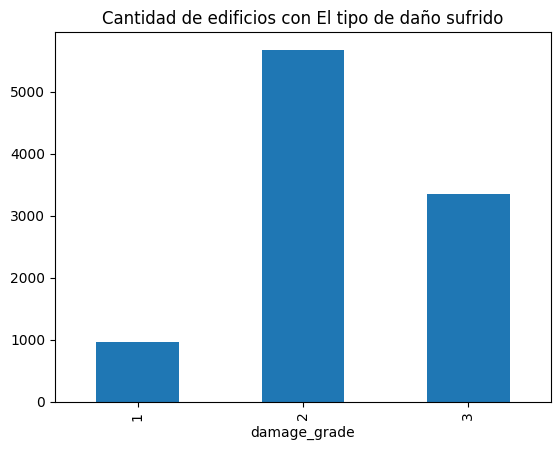

In [123]:
(train_labels_df.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Cantidad de edificios con El tipo de daño sufrido"))

In [169]:
selected_features = ['foundation_type',
                     'area_percentage',
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

X_train_values = train_values_df[selected_features]

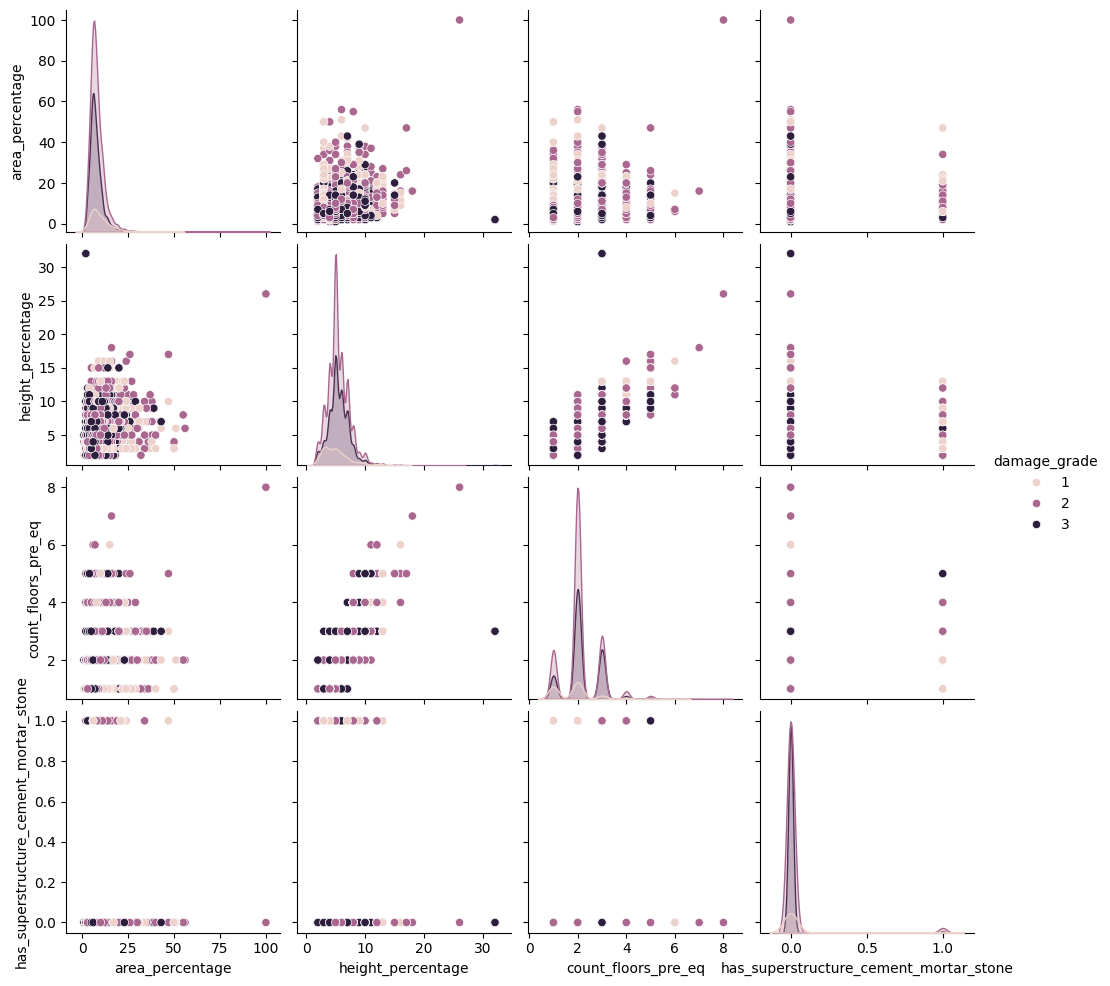

In [125]:
sns.pairplot(X_train_values.join(train_labels_df),
             hue='damage_grade')

# One hot encoder
Lo ejecutamos por medio del pd.get_dummies() de pandas en vez de la clase de scikit-Learn.

Es un enfoque más directo ya que pd.get_dummies() identifica automáticamente todas las columnas que contienen datos categóricos y las transforma en nuevas columnas binarias usando la codificación one-hot

In [126]:
# Aplicamos One-Hot Encoding a las características categóricas
X_train_encoded = pd.get_dummies(X_train_values)

#Escalamiento del conjunto de datos

mirar la normalizacion de datos si es util en este caso

In [127]:
X_train_encoded.columns

Index(['area_percentage', 'height_percentage', 'count_floors_pre_eq',
       'has_superstructure_cement_mortar_stone', 'foundation_type_h',
       'foundation_type_i', 'foundation_type_r', 'foundation_type_u',
       'foundation_type_w', 'land_surface_condition_n',
       'land_surface_condition_o', 'land_surface_condition_t'],
      dtype='object')

In [130]:
# Inicializamos StandardScaler y ajustar-transformar las características numéricas
scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)

Verificación del estado de los datos:

- Los valores de la media después del escalado son muy cercanos a cero, lo cual es lo esperado
- Los valores de la desviación estándar después del escalado son aproximadamente uno para todas las características, lo cual es la característica deseada

In [132]:
# Verificación de la media y desviación estándar después del escalado
mean_values = np.mean(X_train_encoded_scaled, axis=0)
std_values = np.std(X_train_encoded_scaled, axis=0)

print("Media después del escalado:", mean_values)
print("Desviación estándar después del escalado:", std_values)


Media después del escalado: [-1.97550636e-16  3.41094623e-17  2.52978512e-16  3.33988485e-17
  5.32960348e-19 -8.34971212e-17  9.34457143e-17  2.20290277e-17
  3.55306899e-18 -7.10613797e-17  0.00000000e+00  7.67462901e-17]
Desviación estándar después del escalado: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Visualización del estado de los datos

Visualizamos los datos antes y despues de la codificación con One Hot.

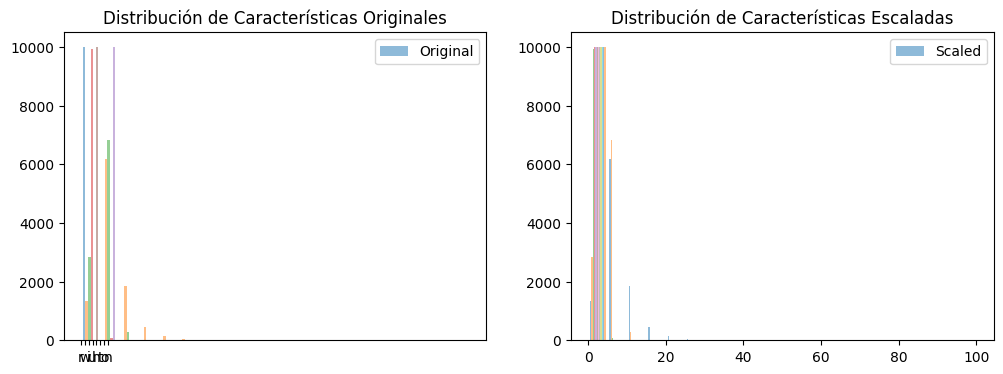

In [134]:
# Visualización de histogramas de características originales y escaladas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(X_train_values.values, bins=20, alpha=0.5, label='Original')
axs[0].set_title('Distribución de Características Originales')
axs[0].legend()

axs[1].hist(X_train_encoded, bins=20, alpha=0.5, label='Scaled')
axs[1].set_title('Distribución de Características Escaladas')
axs[1].legend()

plt.show()

Volvemos a hacer la visualización antes de realizar el escalado de datos al conjunto de datos, con el one hot aplicado ya.

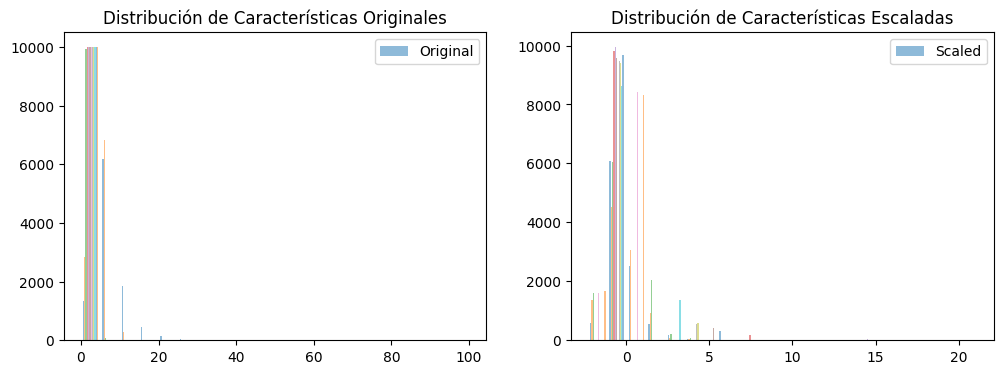

In [135]:
# Visualización de histogramas de características originales y escaladas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(X_train_encoded.values, bins=20, alpha=0.5, label='Original')
axs[0].set_title('Distribución de Características Originales')
axs[0].legend()

axs[1].hist(X_train_encoded_scaled, bins=20, alpha=0.5, label='Scaled')
axs[1].set_title('Distribución de Características Escaladas')
axs[1].legend()

plt.show()

División del conjunto de datos

In [136]:
# Obtenemos las etiquetas correspondientes a los datos de entrenamiento
y_train_labels = train_labels_df["damage_grade"]

# Dividimos el conjunto de datos en X_train (80%) y X_test (20%) junto con y_train (etiquetas correspondientes)
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded_scaled, y_train_labels, test_size=0.2, random_state=42)

# Codificamos la variable objetivo (damage_grade) con LabelEncoder si es necesario
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Dividimos X_train nuevamente en X_train (75%) y X_val (25%)
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded, test_size=0.25, random_state=42)



In [137]:
df_X_train = pd.DataFrame(X_train)
df_X_val = pd.DataFrame(X_val)
df_X_test = pd.DataFrame(X_test)

# Eliminar las columnas duplicadas, manteniendo la primera aparición de cada columna
X_train = df_X_train.loc[:, ~df_X_train.columns.duplicated()]
X_val = df_X_val.loc[:, ~df_X_val.columns.duplicated()]
X_test = df_X_test.loc[:, ~df_X_test.columns.duplicated()]

Comprobar desbalanceo de datos.

In [138]:
# Crear un DataFrame para las etiquetas del conjunto de entrenamiento
df_train = pd.DataFrame({'damage_grade': y_train_encoded})

# Contar las ocurrencias de cada clase en y_train
class_counts_train = df_train['damage_grade'].value_counts()

# Calcular la proporción de cada clase en y_train
class_proportions_train = class_counts_train / len(y_train_encoded)

print("Frecuencia de clases en y_train:")
print(class_counts_train)
print("\nProporción de clases en y_train:")
print(class_proportions_train)


Frecuencia de clases en y_train:
damage_grade
1    3407
2    2001
0     591
Name: count, dtype: int64

Proporción de clases en y_train:
damage_grade
1   0.57
2   0.33
0   0.10
Name: count, dtype: float64


Comprobamos un gran desbalanceo de datos, pasamos a intentar corregirlos usando técnicas de remuestreo con SMOTE, de la librería imbalanced-learn

In [139]:
# Inicializamos SMOTE
smote = SMOTE(random_state=42)

# Aplicamos SMOTE solo al conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Verificamos las proporciones de clases después de aplicar SMOTE
print("Frecuencia de clases en y_train_resampled:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Frecuencia de clases en y_train_resampled:
2   0.33
1   0.33
0   0.33
Name: proportion, dtype: float64


In [140]:
# Creamos un DataFrame para las etiquetas del conjunto de entrenamiento
df_train = pd.DataFrame({'damage_grade': y_train_resampled})

# Contamos las ocurrencias de cada clase en y_train
class_counts_train = df_train['damage_grade'].value_counts()

# Calculamos la proporción de cada clase en y_train
class_proportions_train = class_counts_train / len(y_train_resampled)

print("Frecuencia de clases en y_train:")
print(class_counts_train)
print("\nProporción de clases en y_train:")
print(class_proportions_train)

Frecuencia de clases en y_train:
damage_grade
2    3407
1    3407
0    3407
Name: count, dtype: int64

Proporción de clases en y_train:
damage_grade
2   0.33
1   0.33
0   0.33
Name: count, dtype: float64


#Dendograma

In [ ]:
# X_train_resampled
y_train_resampled

In [181]:
# Para obtener el dendograma con el agrupamiento por características, se hace necesario obtener la transpuesta de la matriz del dataset
X_train_resampled.columns.to_list()

X_train_resampled_T = X_train_resampled.T
X_train_resampled_T

,0,1,2,3,4,5,6,7,8,9,...,10211,10212,10213,10214,10215,10216,10217,10218,10219,10220
0,-0.46,-0.01,0.22,-0.23,-0.46,-0.23,-0.23,0.91,-0.23,-1.15,...,-0.23,0.97,-0.23,-0.01,-1.15,-0.69,-0.42,0.16,-0.79,0.45
1,-0.74,-0.74,-0.22,0.82,0.30,0.30,-0.74,0.30,-0.22,-0.74,...,-0.74,2.00,-1.77,0.30,0.30,-0.74,0.30,0.30,-0.22,0.30
2,-0.16,-0.16,-0.16,1.22,-0.16,1.22,-0.16,-0.16,-0.16,-0.16,...,-1.54,1.22,-1.54,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,1.22
3,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,...,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13
4,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,...,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07
5,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,...,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21
6,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,...,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,-2.30,0.43
7,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,...,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,-0.24,4.19,-0.24
8,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,...,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
9,-0.40,-0.40,-0.40,-0.40,-0.40,-0.40,-0.40,-0.40,-0.40,-0.40,...,-0.40,-0.40,2.52,-0.40,-0.40,-0.40,2.52,2.52,-0.40,-0.40


Distancia Media	 147.46


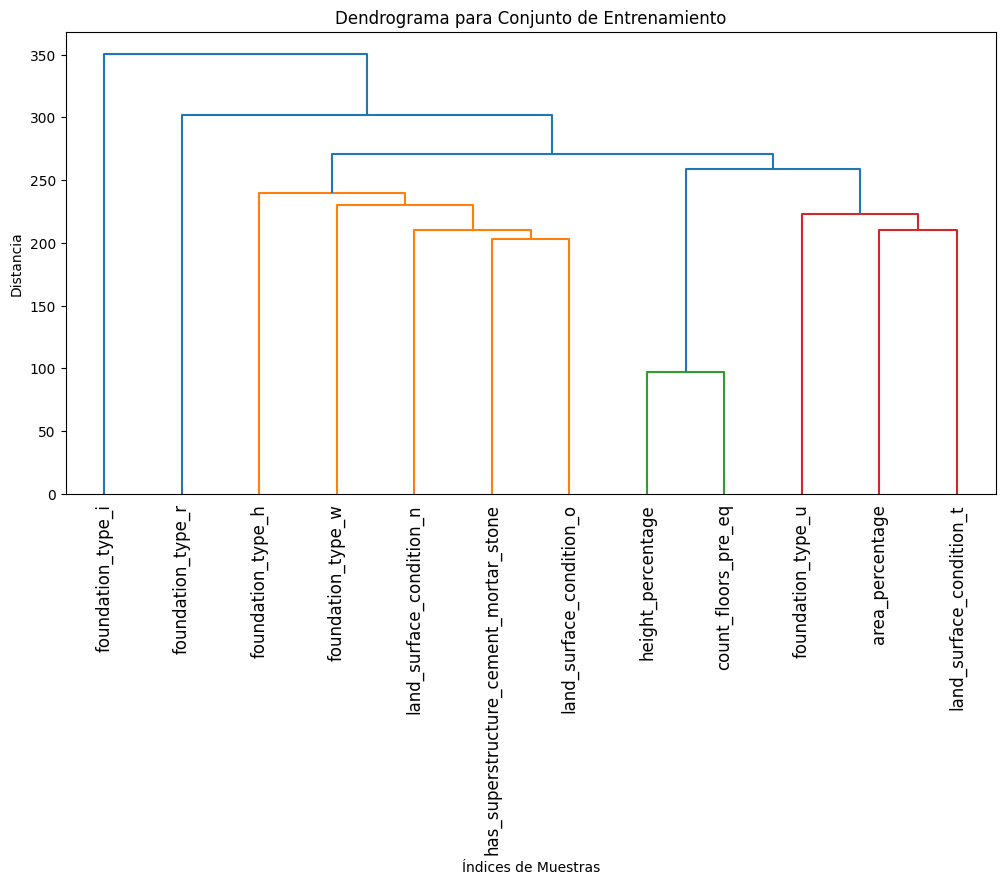

In [198]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(X_train_resampled_T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Constuimos el dendograma
# Recordar que el valor de corte del dendograma (threshold) debe fijarse a mano.
# Hemos decidido que 50 es un buen valor en estos datos. Tener en cuenta que no hay una solución correcta.

from scipy import cluster
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.title('Dendrograma para Conjunto de Entrenamiento')
plt.xlabel('Índices de Muestras')
plt.ylabel('Distancia')
# threshold_2 = 50
threshold_2 = 255
# Seleccionamos como distancia intercluster el vecino más alejado (complete)
clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=threshold_2, labels=X_train_encoded.columns.to_list(), leaf_rotation=90)
plt.show()

#SelectKBest

In [143]:
# X_train
# X_test
# X_val
# y_train_encoded
# y_test
# y_val_encoded

In [203]:
# Inicializa SelectKBest con f_classif como función de puntuación y k=4
selector = SelectKBest(f_classif, k=3)

# Ajusta el selector con los datos de entrenamiento escalados y las etiquetas de entrenamiento
selector.fit(X_train_resampled, y_train_resampled)

# Obtén las características seleccionadas
selected_indices = selector.get_support(indices=True)
selected_features = [X_train_resampled.columns[i] for i in selected_indices]

# Transforma conjuntos de entrenamiento, validación y prueba
X_train_selected = selector.transform(X_train_resampled)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Imprime las características seleccionadas
print("Características seleccionadas:", selected_features)

Características seleccionadas: [2, 5, 6]


#Cross Validation
Aplicamos Cross Validation a los conjuntos de datos

In [145]:
# cv = KFold(n_splits = 10, shuffle=True, random_state=42)

# for train_fold, test_fold in cv.split(X_train_selected):  # Recorre las particiones
#   X_train_fold = X_train_selected[train_fold]  # Separa datos de entrenamiento para la partición actual
#   X_test_fold = X_train_selected[test_fold]    # Separa datos de prueba para la partición actual

# depth_range = range(1, X_train_selected.shape[1]* 3 + 1) # Definimos un rango de valores para la profundidad máxima que se aplicará a los distintos árboles e hiperparámetros



In [146]:
cv = KFold(n_splits = 10, shuffle=True, random_state=42)

In [147]:
print("Distribución inicial de y_train:")
print(pd.Series(y_train_resampled).value_counts())

Distribución inicial de y_train:
2    3407
1    3407
0    3407
Name: count, dtype: int64


# Modelo: SVC

In [148]:
# Crear y entrenar el modelo SVC
svc_model = SVC(kernel='linear', probability=True)

# Lista para almacenar los resultados de validación cruzada
accuracy_scores = []
recall_scores = []
f1_scores = []

# Realiza validación cruzada con KFold
for train_index, val_index in cv.split(X_train_selected):
    X_train_fold, X_val_fold = X_train_selected[train_index], X_train_selected[val_index]
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]

    # Entrena el modelo SVC en cada fold
    svc_model.fit(X_train_fold, y_train_fold)

    # Predice en el conjunto de validación
    y_pred_fold = svc_model.predict(X_val_fold)

    # Calcula y almacena las métricas de evaluación
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    recall_scores.append(recall_score(y_val_fold, y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold, average='weighted'))

# Imprime los resultados de la validación cruzada
print("Accuracy promedio en la validación cruzada:", sum(accuracy_scores) / len(accuracy_scores))
print("Recall promedio en la validación cruzada:", sum(recall_scores) / len(recall_scores))
print("F1-score promedio en la validación cruzada:", sum(f1_scores) / len(f1_scores))

# Entrenar el modelo final en todo X_train_selected y y_train_resampled
svc_model.fit(X_train_selected, y_train_resampled)

# Predecir en el conjunto de prueba
y_pred_test = svc_model.predict(X_test_selected)

class_report = classification_report(y_test, y_pred_test)
print("Reporte de clasificación:")
print(class_report)

Accuracy promedio en la validación cruzada: 0.5020071620822837
Recall promedio en la validación cruzada: 0.5020071620822837
F1-score promedio en la validación cruzada: 0.40520729629109853
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       173
           2       0.57      0.84      0.68      1140
           3       0.00      0.00      0.00       687

    accuracy                           0.48      2000
   macro avg       0.14      0.21      0.17      2000
weighted avg       0.32      0.48      0.39      2000



In [149]:
print("y_test ->",  pd.Series(y_test).value_counts())
print("\ny_pred_test ->\n",pd.Series(y_pred_test).value_counts())

y_test -> damage_grade
2    1140
3     687
1     173
Name: count, dtype: int64

y_pred_test ->
 2    1702
0     298
Name: count, dtype: int64


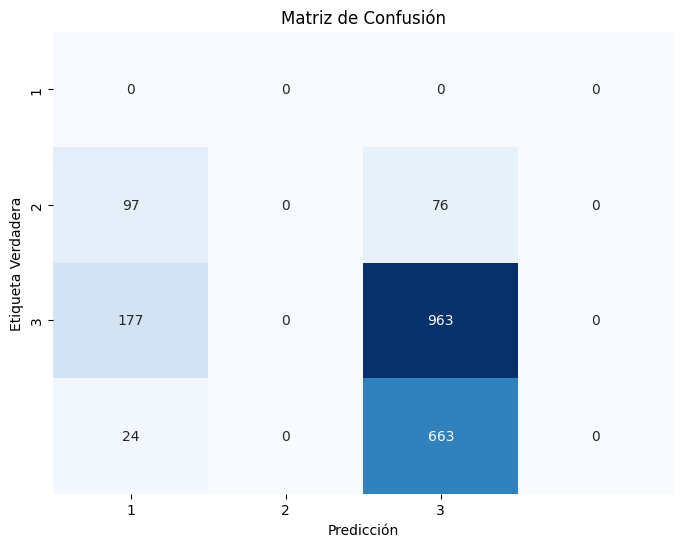

In [150]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualiza la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

------------
# Aplicando Gridsearch y RandomizedSearch para la mejora de características

Gridsearch

In [151]:
# # Definir los parámetros
# param_dist_grdsrch = {
#     'C': [1, 3, 4, 5],        # Parámetro de regularización
#     'gamma': [0.001, 0.01, 0.1, 1], # Parámetro del kernel (para 'rbf')
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']    # Tipo de kernel
# }

# # Inicializar GridSearchCV
# grid_search_svc = GridSearchCV(svc_model,
#                                param_dist_grdsrch,
#                                cv=cv,
#                                scoring='accuracy',
#                                verbose=1, n_iter=30)

# # Ajustar GridSearchCV a los datos
# grid_search_svc.fit(X_train_selected, y_train_resampled)

# # Mostrar los mejores parámetros encontrados y VC
# print("Mejores parámetros:", grid_search_svc.best_params_)
# print("Mejor puntuación de validación cruzada:", grid_search_svc.best_score_)

# # Mejor modelo
# best_svc_model = grid_search_svc.best_estimator_

# test_accuracy = best_svc_model.score(X_test_selected, y_test)
# print("Precisión en el conjunto de prueba:", test_accuracy)

RandomizedSearch

In [152]:
# svc_param_dist = {
#     'C': [100, 150, 275, 500],  # Parámetro de regularización
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel a utilizar
#     'gamma': ['scale', 'auto','float'],  # Coeficiente del kernel ('scale' es 1 / (n_features * X.var()) y 'auto' es 1 / n_features)
#     'degree': [2, 3, 4, 5],  # Grado de la función del kernel (solo para kernel polinomial)
#     'shrinking': [True, False],  # Usa la heurística de encolamiento
#     'class_weight': [None, 'balanced']  # Peso asociado a las clases
# }

In [153]:
# # Inicializar RandomizedSearchCV
# random_search_svm = RandomizedSearchCV(estimator=svc_model, param_distributions=svc_param_dist,
#                                    cv=cv, scoring='accuracy', verbose=1, n_iter=30)

# # Ajustar RandomizedSearchCV a los datos
# random_search_svm.fit(X_train_resampled, y_train_resampled)

# # Mostrar los mejores parámetros encontrados
# print("Mejores parámetros:", random_search_svm.best_params_)

# # Mostrar la mejor puntuación de validación cruzada
# print("Mejor puntuación de validación cruzada:", random_search_svm.best_score_)

# # Obtener el mejor modelo
# best_svc_model2 = random_search_svm.best_estimator_
# best_svc_model2.set_params(probability=True)

# # Evaluar el modelo en el conjunto de prueba
# test_accuracy2 = best_svc_model2.score(X_test_selected, y_test)
# print("Precisión en el conjunto de prueba:", test_accuracy2)

---------
# Prueba Librería Lazy Predict

In [154]:
# Inicializa LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Ajustar LazyClassifier a los datos
# models_summary, _ = clf.fit(X_train, X_test, y_train, y_test)
models_summary, _ = clf.fit(X_train_resampled, X_test_selected, y_train_resampled, y_test)

# Muestra el resumen de los modelos
print(models_summary)

 97%|█████████▋| 28/29 [01:01<00:03,  3.02s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 10221, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 29/29 [01:03<00:00,  2.18s/it]

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


In [155]:
# X_train_resampled
# X_test_selected
# y_train_resampled
# y_test

Probamos la librería de código abierto H2O, que ofrece capacidades de automatización, como AutoML, que al igual que Lazy predict, ayuda a encontrar automáticamente el mejor modelo y ajuste para un problema específico.
Como detalle a tener en cuenta, H2O es escalable y puede ejecutarse en múltiples entornos, desde máquinas individuales hasta clústeres distribuidos.

Usando los conjuntos de datos que hemos desarrollado, H2O ha entrenado una variedad de modelos para resolver el problema. Estos incluyen algoritmos como Gradient Boosting Machines (GBM), Generalized Linear Models (GLM), XGBoost, y Random Forests (XRT). Además, se han generado modelos ensamblados (StackedEnsemble) los cuales mejoran la precisión general combinando características de varios algoritmos. Cada modelo tiene configuraciones específicas y han sido evaluados utilizando métricas como RMSE, MSE, y MAE para seleccionar el mejor candidato. Esta estrategia diversa permite explorar diferentes enfoques y optimizar el rendimiento del modelo final.

In [156]:
# Inicializar H2O
h2o.init()

# Convertir y_train a una lista
y_train_list = y_train_resampled.tolist()

# Convertir los datos a H2OFrame
train_data = h2o.H2OFrame(X_train_resampled)
# train_data = h2o.H2OFrame(y_train_resampled)
val_data = h2o.H2OFrame(X_val_selected)
test_data = h2o.H2OFrame(X_test_selected)

# Agregar la columna objetivo a train_data y val_data
train_data['damage_grade'] = h2o.H2OFrame(y_train_list)
val_data['damage_grade'] = h2o.H2OFrame(y_val_encoded.tolist())

# Definir columnas de entrada y columna objetivo
x = train_data.columns[:-1]
y = 'damage_grade'

# Crear y entrenar un modelo AutoML
aml = H2OAutoML(max_models=10, seed=42)
aml.train(x=x, y=y, training_frame=train_data, validation_frame=val_data)

# Ver los modelos clasificados por rendimiento
lb = aml.leaderboard
print(lb)

# Obtener el modelo líder
best_model = aml.leader

# # Hacer predicciones en los datos de prueba
# predictions = best_model.predict(test_data)

# # Mostrar las predicciones
# print(predictions)



Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 16 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,"28 days, 3 hours and 10 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_thdtwg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.062 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:32:27.758: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML

Modelo elegido gracias a la librería H2O:

#GBoost

In [157]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear y entrenar el modelo GBM
gbm_model = GradientBoostingClassifier(random_state=1)  # Puedes ajustar otros hiperparámetros aquí

# Lista para almacenar los resultados de validación cruzada
accuracy_scores_2 = []
recall_scores_2 = []
f1_scores_2 = []

# Realizar validación cruzada con KFold
# kf = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation
for train_index_2, val_index_2 in cv.split(X_train_selected):
    X_train_fold_2, X_val_fold_2 = X_train_selected[train_index_2], X_train_selected[val_index_2]
    y_train_fold_2, y_val_fold_2 = y_train_resampled[train_index_2], y_train_resampled[val_index_2]

    # Entrenar el modelo GBM en cada fold
    gbm_model.fit(X_train_fold_2, y_train_fold_2)

    # Predecir en el conjunto de validación
    y_pred_gbm_fold = gbm_model.predict(X_val_fold_2)

    # Calcular y almacenar las métricas de evaluación
    accuracy_scores.append(accuracy_score(y_val_fold_2, y_pred_gbm_fold))
    recall_scores.append(recall_score(y_val_fold_2, y_pred_gbm_fold, average='weighted'))
    f1_scores.append(f1_score(y_val_fold_2, y_pred_gbm_fold, average='weighted'))

# Imprimir los resultados de la validación cruzada
print("Accuracy promedio en la validación cruzada:", sum(accuracy_scores) / len(accuracy_scores))
print("Recall promedio en la validación cruzada:", sum(recall_scores) / len(recall_scores))
print("F1-score promedio en la validación cruzada:", sum(f1_scores) / len(f1_scores))

# Entrenar el modelo final en todo X_train_selected y y_train_resampled
gbm_model.fit(X_train_selected, y_train_resampled)

# Predecir en el conjunto de prueba
y_pred_test = gbm_model.predict(X_test_selected)

# Imprimir el reporte de clasificación en el conjunto de prueba
class_report = classification_report(y_test, y_pred_test)
print("Reporte de clasificación:")
print(class_report)


Accuracy promedio en la validación cruzada: 0.5091486801606113
Recall promedio en la validación cruzada: 0.5091486801606113
F1-score promedio en la validación cruzada: 0.4190581880813798
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      0.04      0.06       173
           2       0.57      0.72      0.64      1140
           3       0.00      0.00      0.00       687

    accuracy                           0.41      2000
   macro avg       0.17      0.19      0.17      2000
weighted avg       0.33      0.41      0.37      2000



Generar salida para el test de la competición

In [ ]:

# building_id	damage_grade
# 11456	1
# 16528	1
# 3253	1

In [ ]:
res = gbm_model.predict(y_pred_test[selected_features])
output = pd.DataFrame({ 'building_id': y_pred_test['building_id'], 'damage_grade': res})
output.head()

In [160]:
gbm_model.fit(X_train_selected, y_train_resampled)

# Predecir en el conjunto de prueba
y_pred_test = gbm_model.predict(X_test_selected)

# Crear DataFrame de salida con las predicciones
output = pd.DataFrame({'building_id': X_test_selected['building_id'], 'damage_grade': y_pred_test})
output.head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('result.csv')

In [161]:
# Crear y entrenar el modelo GBM
gbm_model = GradientBoostingClassifier(random_state=1)  # Puedes ajustar otros hiperparámetros aquí

# Realizar validación cruzada con KFold
# Suponiendo que 'cv' es el objeto de validación cruzada configurado previamente
accuracy_scores = cross_val_score(gbm_model, X_train_selected, y_train_resampled, cv=cv, scoring='accuracy')
recall_scores = cross_val_score(gbm_model, X_train_selected, y_train_resampled, cv=cv, scoring='recall_weighted')
f1_scores = cross_val_score(gbm_model, X_train_selected, y_train_resampled, cv=cv, scoring='f1_weighted')

# Imprimir los resultados de la validación cruzada
print("Accuracy promedio en la validación cruzada:", accuracy_scores.mean())
print("Recall promedio en la validación cruzada:", recall_scores.mean())
print("F1-score promedio en la validación cruzada:", f1_scores.mean())

# Entrenar el modelo final en todo X_train_selected y y_train_resampled
gbm_model.fit(X_train_selected, y_train_resampled)

# Predecir en el conjunto de prueba
y_pred_test = gbm_model.predict(X_test_selected)

# Imprimir el reporte de clasificación en el conjunto de prueba
class_report = classification_report(y_test, y_pred_test)
print("Reporte de clasificación:")
print(class_report)

# Crear el DataFrame de salida con las predicciones
output = pd.DataFrame({'building_id': X_test_selected['building_id'], 'damage_grade': y_pred_test})
output.head()


Accuracy promedio en la validación cruzada: 0.5162901982389388
Recall promedio en la validación cruzada: 0.5162901982389388
F1-score promedio en la validación cruzada: 0.4329090798716611
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      0.04      0.06       173
           2       0.57      0.72      0.64      1140
           3       0.00      0.00      0.00       687

    accuracy                           0.41      2000
   macro avg       0.17      0.19      0.17      2000
weighted avg       0.33      0.41      0.37      2000



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices